In [ ]:
import numpy as np
from numpy.random import seed
import os
seed(23)
os.environ["PYTHONHASHSEED"] = "0"
np.random.seed(23)
tf.random.set_seed(23)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r ./drive/MyDrive/ICNA_hackathon/ ./
!unzip ./ICNA_hackathon/FordA.zip

Archive:  ./ICNA_hackathon/FordA.zip
   creating: FordA/
  inflating: FordA/config.json       
  inflating: FordA/data.pkl          
  inflating: FordA/FordA_TEST.ts     
  inflating: FordA/FordA_TRAIN.ts    
   creating: FordA/.ipynb_checkpoints/
  inflating: FordA/.ipynb_checkpoints/config-checkpoint.json  
  inflating: FordA/.ipynb_checkpoints/FordA_TEST-checkpoint.ts  
  inflating: FordA/.ipynb_checkpoints/FordA_TRAIN-checkpoint.ts  


In [ ]:
import numpy as np
from helper import Helper

helper = Helper()
file_train = "./FordA/FordA_TRAIN.ts"
file_test = "./FordA/FordA_TEST.ts"
x_train, y_train = helper.data_processing(file_train)
x_test, y_test = helper.data_processing(file_test)

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)


(3601, 500, 1)
(3601,)
(1320, 500, 1)


In [ ]:
# Unzip pretrained transformer_time2vec model

# !cp -r ./drive/MyDrive/ICNA_hackathon/ ./
!tar -xvf ./ICNA_hackathon/transformer_time2vec.tar.gz

./transformer_time2vec/
./transformer_time2vec/keras_metadata.pb
./transformer_time2vec/variables/
./transformer_time2vec/variables/variables.index
./transformer_time2vec/variables/variables.data-00000-of-00001
./transformer_time2vec/saved_model.pb
./transformer_time2vec/assets/


In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

In [ ]:
input_shape = x_train.shape[1:]

# create the first transformer without time_to_vector
def create_transformer_one():
  batch_size = 32
  seq_len = 500

  d_k = 256
  d_v = 256
  n_heads = 12
  ff_dim = 256 
   
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 1))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='sigmoid')(x)


  model = Model(inputs=in_seq, outputs=out)
  model = load_model("./transformer_time2vec")
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["binary_accuracy"])
  
  return model


In [ ]:
# create sklearn voting classer wraper for Keras model
time2vec = keras.wrappers.scikit_learn.KerasClassifier(lambda: create_model(),
                                                  epochs=10, batch_size=16,
                                                  verbose=True)
time2vec._estimator_type = "classifier"

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
# unzip pre-trained model of the second transformer 
!tar -xvf ./ICNA_hackathon/transformer_ba.tar.gz

./transformer_ba/
./transformer_ba/keras_metadata.pb
./transformer_ba/variables/
./transformer_ba/variables/variables.index
./transformer_ba/variables/variables.data-00000-of-00001
./transformer_ba/saved_model.pb
./transformer_ba/assets/


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    # outputs = layers.Dense(n_classes, activation="softmax")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model = load_model("./transformer_ba")
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["binary_accuracy"],)
    
    
    return model
  
    
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.evaluate(x_test, y_test, verbose=1)

42/42 [==============================] - 4s 81ms/step - loss: 0.3693 - binary_accuracy: 0.8371


[0.3692592680454254, 0.8371211886405945]

In [ ]:
# create sklearn voting classer wraper for Keras model
transformer = keras.wrappers.scikit_learn.KerasClassifier(lambda: build_model(
                                                                              input_shape,
                                                                              head_size=256,
                                                                              num_heads=4,
                                                                              ff_dim=4,
                                                                              num_transformer_blocks=4,
                                                                              mlp_units=[128],
                                                                              mlp_dropout=0.4,
                                                                              dropout=0.25,), 
                                                          epochs=1, batch_size=64,verbose=True)
transformer._estimator_type = "classifier"

In [ ]:
from sklearn.model_selection import cross_val_score

voting2 = VotingClassifier(estimators=[("Time2vec",time2vec), ("Transformer", transformer)], voting='soft',flatten_transform=True)
voting2.fit(x_train, y_train)

Epoch 1/10
226/226 [==============================] - 89s 327ms/step - loss: 0.4932 - binary_accuracy: 0.7667
Epoch 2/10
226/226 [==============================] - 73s 325ms/step - loss: 0.4514 - binary_accuracy: 0.7998
Epoch 3/10
226/226 [==============================] - 75s 330ms/step - loss: 0.4276 - binary_accuracy: 0.8103
Epoch 4/10
226/226 [==============================] - 74s 325ms/step - loss: 0.3939 - binary_accuracy: 0.8295
Epoch 5/10
226/226 [==============================] - 73s 325ms/step - loss: 0.3617 - binary_accuracy: 0.8517
Epoch 6/10
226/226 [==============================] - 73s 325ms/step - loss: 0.3285 - binary_accuracy: 0.8636
Epoch 7/10
226/226 [==============================] - 73s 325ms/step - loss: 0.2988 - binary_accuracy: 0.8759
Epoch 8/10
226/226 [==============================] - 73s 325ms/step - loss: 0.2682 - binary_accuracy: 0.8911
Epoch 9/10
226/226 [==============================] - 73s 325ms/step - loss: 0.2440 - binary_accuracy: 0.9047
Epoch 10/1

VotingClassifier(estimators=[('Transformer',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9d84273190>),
                             ('Time2vec',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9d99936550>),
                             ('Transformer',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9d99943790>)],
                 voting='soft')

In [ ]:
from sklearn import metrics

y_pred = voting2.predict(x_test)
y_pred = np.where(y_pred > 0.5,1,0)


cm = metrics.confusion_matrix(y_test, y_pred)
balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
print(cm)
print(balanced_accuracy)

[[627  54]
 [ 65 574]]
0.9094917030326846


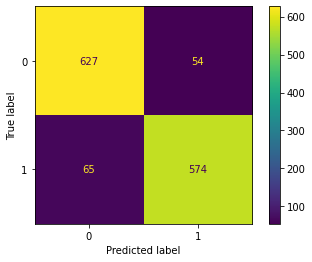

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(voting2, x_test, y_test)  
plt.savefig("confusion_matrix_90.png", dpi=300)
plt.show()